## Finding Arduino Ports
When working with Arduino, it's essential to know which port your Arduino board is connected to on your computer. This is necessary for uploading code and communicating with the board. Each port is identified by a unique name or number, depending on the operating system:

- On Windows, ports are named like `COM3`, `COM4`, etc.
- On macOS and Linux, ports are named like `/dev/ttyUSB0`, `/dev/ttyACM0`, etc.

Run the next cell to know the port number.


In [1]:
import serial.tools.list_ports

def list_all_ports():
    ports = serial.tools.list_ports.comports()

    if not ports:
        print("No serial ports found.")
    else:
        print("Available serial ports:")
        for port in ports:
            print(f"Port: {port.device}, Description: {port.description}")

list_all_ports()

Available serial ports:
Port: COM4, Description: USB Serial Device (COM4)


#### Setup the serial communication with arduino

Change the port value in the next cell with the result that you got in the previous cell

In [2]:
import serial
import time

port = 'COM4' 

ser = serial.Serial(port, 115200)

time.sleep(2)

## Command to read the voltage
Use the following command `readvoltage` at the next prompt to start recording the photo diode current.

Sequence of operations:
- Enter the command `readvoltage`
- Wait for 10sec (Wait until you see the text "Received stop command.")
- Hold the temperature sensor with your fingers
- Enter the command `readvoltage`
- Wait for 10sec (Wait until you see the text "Received stop command.")


Below shown is the thermister data measurement setup:
![thermister data measurement setup](thermister_image.jpg)


In [25]:
import matplotlib.pyplot as plt
import csv

data_loading_delay = 100
data_loading_counter = 0

read_data_from_csv = 0

# Initialize empty lists to store each column
voltage_without_finger = []
voltage_with_finger = []

if read_data_from_csv == 0:
    print("Type your command:")
    command = input("> ").strip()
    ser.write((command + '\n').encode())
    
    try:
        print("Reading data ...", end= "")
        data_loading_counter = 0
        while True:
            # Read a line of data from the serial port
            if ser.in_waiting > 0:
                data_loading_counter = data_loading_counter + 1
                if(data_loading_counter == data_loading_delay):
                    data_loading_counter = 0
                    print(".", end = "")
                line = ser.readline().decode('utf-8').strip()
                
                # Check if the line contains "Ready to enter next command"
                if "Ready to enter next command" in line:
                    print()
                    print("Received stop command.")
                    break

                voltage_without_finger.append(line)
    
    except KeyboardInterrupt:
        print("Data collection interrupted.")

else:
    with open('temp_data_without_finger.csv', mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            voltage_without_finger.append(float(row[0])) 
            

if read_data_from_csv == 0:
    print("Type your command:")
    command = input("> ").strip()
    ser.write((command + '\n').encode())
    
    try:
        print("Reading data ...", end= "")
        data_loading_counter = 0
        while True:
            # Read a line of data from the serial port
            if ser.in_waiting > 0:
                data_loading_counter = data_loading_counter + 1
                if(data_loading_counter == data_loading_delay):
                    data_loading_counter = 0
                    print(".", end = "")
                line = ser.readline().decode('utf-8').strip()
                
                # Check if the line contains "Ready to enter next command"
                if "Ready to enter next command" in line:
                    print()
                    print("Received stop command.")
                    break
                voltage_with_finger.append(line)
                
    
    except KeyboardInterrupt:
        print("Data collection interrupted.")

else:
    with open('temp_data_with_finger.csv', mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            voltage_with_finger.append(float(row[0]))

Type your command:


>  readvoltage


Reading data .......................................................................................................
Received stop command.
Type your command:


>  readvoltage


Reading data .......................................................................................................
Received stop command.


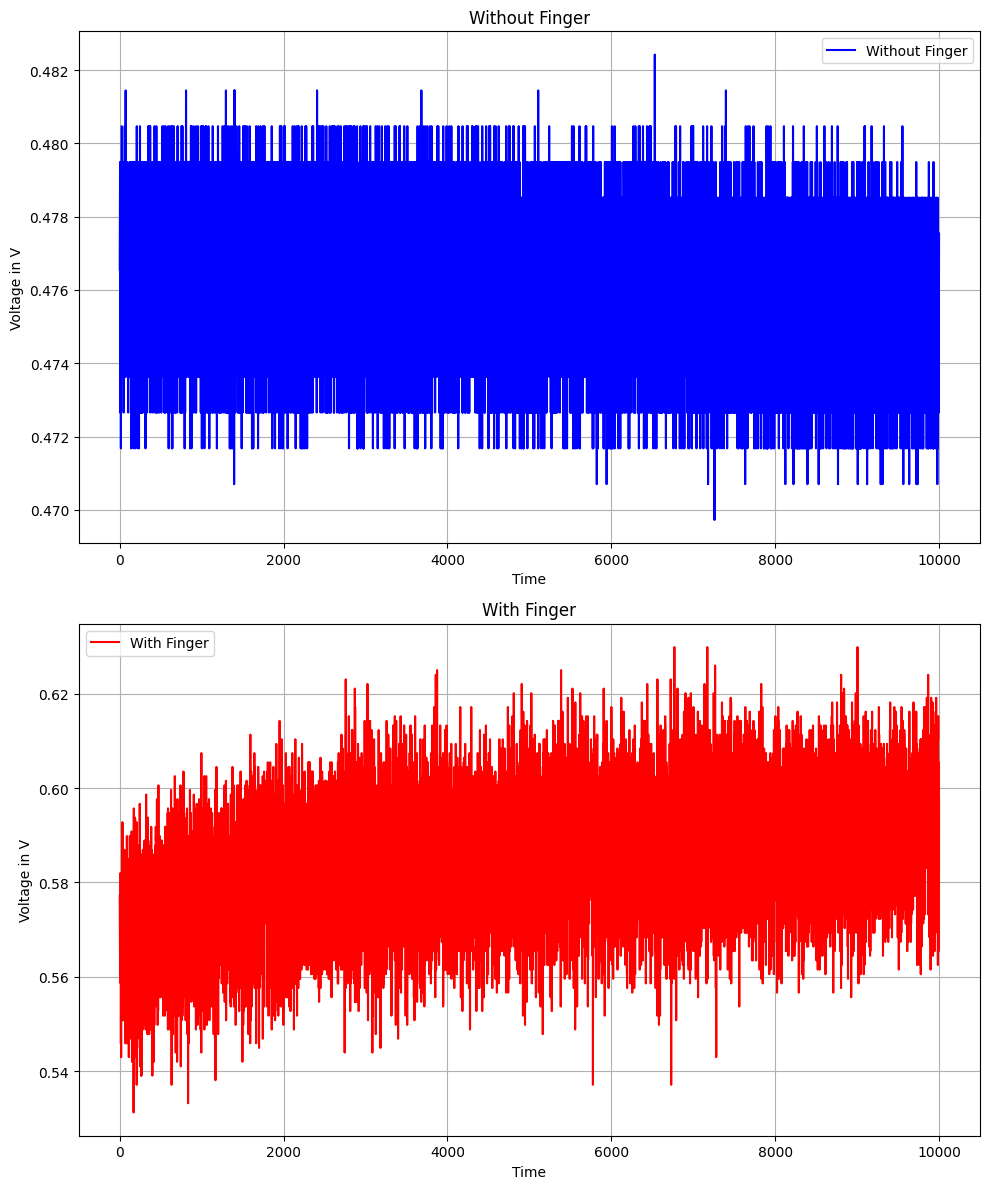

In [26]:
# Convert strings to integers
voltage_without_finger = list(map(int, voltage_without_finger))
voltage_with_finger = list(map(int, voltage_with_finger))

voltage_without_finger = [ v/1024 for v in voltage_without_finger]
voltage_with_finger = [ v/1024 for v in voltage_with_finger]


plt.figure(figsize=(10, 12))

# First subplot for 'Without Finger' data
plt.subplot(2, 1, 1) 
plt.plot(voltage_without_finger, label='Without Finger', color='blue')
plt.xlabel('Time')
plt.ylabel('Voltage in V')
plt.title('Without Finger')
plt.legend()
plt.grid(True)

# Second subplot for 'With Finger' data
plt.subplot(2, 1, 2)
plt.plot(voltage_with_finger, label='With Finger', color='red')
plt.xlabel('Time')
plt.ylabel('Voltage in V')
plt.title('With Finger')
plt.legend()
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [27]:
import math

average_voltage_without_finger = 3.3*sum(voltage_without_finger)/len(voltage_without_finger)
average_voltage_with_finger = 3.3*sum(voltage_with_finger[9000:])/len(voltage_with_finger[9000:])

# print("Average voltage without finger:", end = " ")
# print(average_voltage_without_finger*1000, end = " ")
# print("mV")
# print("Average voltage with finger", end = " ")
# print(average_voltage_with_finger*1000, end = " ")
# print("mV")

R0 = 10000*((3.3/average_voltage_without_finger)-1)
R = 10000*((3.3/average_voltage_with_finger)-1)

# print(R0)
# print(R)

beta = 3950
T0 = 24

def calculate_temperature(R, R0, T0, beta):
    # Convert room temperature (T0) from Celsius to Kelvin
    T0_kelvin = T0 + 273.15

    # Apply the thermistor equation to calculate temperature in Kelvin
    T_kelvin = 1 / ((1 / T0_kelvin) + ((1 / beta) * math.log(R / R0)))

    # Convert temperature back to Celsius
    T_celsius = T_kelvin - 273.15

    return T_celsius

print("Skin temperature: ", end= " ")
print(calculate_temperature(R, R0, T0, beta))

Skin temperature:  34.620764036970854
